Features_df importieren

In [1]:
import pandas as pd

features_df = pd.read_pickle("../data/processed/features.pkl")

X definieren

In [2]:
X = features_df[['month_sin',
                 'month_cos',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'minute_of_day_sin',
                 'minute_of_day_cos',
                'wind_speed_kt',
                'vis_category',
                'temperature_c',
                'spread_c',
                'qnh_hpa',
                'scheduled_departures',
                'scheduled_arrivals',
                'avg_dep_delay_prev_slot_minutes',
                'avg_dep_delay_past_6h',
                'scheduled_dep_cat_C',
                'scheduled_dep_cat_D',
                'scheduled_rwy_concept',
                'arr_dep_ratio'
        ]]

In [3]:
X

,month_sin,month_cos,day_of_week_sin,day_of_week_cos,minute_of_day_sin,minute_of_day_cos,wind_speed_kt,vis_category,temperature_c,spread_c,qnh_hpa,scheduled_departures,scheduled_arrivals,avg_dep_delay_prev_slot_minutes,avg_dep_delay_past_6h,scheduled_dep_cat_C,scheduled_dep_cat_D,scheduled_rwy_concept,arr_dep_ratio
0,0.000000,1.0,-0.781831,0.623490,0.000000,1.000000,9.0,2–5km,10.0,4.0,1023.0,0,0,0.0,0.0,0,0,NaN,0.0
1,0.000000,1.0,-0.781831,0.623490,0.130526,0.991445,3.0,2–5km,10.0,4.0,1023.0,0,0,0.0,0.0,0,0,NaN,0.0
2,0.000000,1.0,-0.781831,0.623490,0.258819,0.965926,8.0,8–10km,11.0,5.0,1023.0,0,0,0.0,0.0,0,0,NaN,0.0
3,0.000000,1.0,-0.781831,0.623490,0.382683,0.923880,6.0,8–10km,13.0,6.0,1023.0,0,0,0.0,0.0,0,0,NaN,0.0
4,0.000000,1.0,-0.781831,0.623490,0.500000,0.866025,7.0,8–10km,14.0,7.0,1023.0,0,0,0.0,0.0,0,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,-0.866025,-0.5,-0.433884,-0.900969,-0.608761,0.793353,3.0,5–8km,10.0,1.0,1020.0,0,0,0.0,0.0,0,0,NaN,0.0
47996,-0.866025,-0.5,-0.433884,-0.900969,-0.500000,0.866025,2.0,5–8km,10.0,1.0,1020.0,0,0,0.0,0.0,0,0,NaN,0.0
47997,-0.866025,-0.5,-0.433884,-0.900969,-0.382683,0.923880,1.0,5–8km,10.0,1.0,1020.0,0,0,0.0,0.0,0,0,NaN,0.0
47998,-0.866025,-0.5,-0.433884,-0.900969,-0.258819,0.965926,4.0,8–10km,10.0,1.0,1020.0,0,0,0.0,0.0,0,0,NaN,0.0


Y definieren

In [4]:
y = features_df[['avg_dep_delay_slot_minutes']]

XGBoost und train_test_split importieren

In [5]:
import xgboost
from sklearn.model_selection import train_test_split

Daten in Trainings-, Validations- und Testset aufteilen

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.4,random_state=42,shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,shuffle=False) 

'''
Daten werden aufgesplittet:
- 60% Training
- 20% Validierung
- 20% Test
'''

'\nDaten werden aufgesplittet:\n- 60% Training\n- 20% Validierung\n- 20% Test\n'

XGBRegressor importieren

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

Hyperparamter-Tuning mit RandomizedSearchCV anhand vom Trainingsset

In [8]:
'''

param_grid = {
    "max_depth": [4, 6, 8, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 1, 2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 2, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [3000]
}

model = XGBRegressor(
    objective = 'reg:squarederror',
    enable_categorical = True,
    random_state = 42,
    early_stopping_rounds = 50,
    n_jobs = -1
)

tscv = TimeSeriesSplit(n_splits=4, gap=4*24)


#You have 30-minute slots → 48 slots = 1 day

#Use TimeSeriesSplit to respect time order

#Optionally leave a gap (e.g. 2–3 days) to avoid leakage

#Perfect for tuning, since it checks the model across multiple time periods


search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
print(search.best_params_)
'''

'\n\nparam_grid = {\n    "max_depth": [4, 6, 8, 10],\n    "min_child_weight": [1, 3, 5],\n    "subsample": [0.8, 1.0],\n    "colsample_bytree": [0.8, 1.0],\n    "gamma": [0, 1, 2],\n    "reg_alpha": [0, 0.1, 0.5],\n    "reg_lambda": [1, 2, 5],\n    "learning_rate": [0.05, 0.1],\n    "n_estimators": [3000]\n}\n\nmodel = XGBRegressor(\n    objective = \'reg:squarederror\',\n    enable_categorical = True,\n    random_state = 42,\n    early_stopping_rounds = 50,\n    n_jobs = -1\n)\n\ntscv = TimeSeriesSplit(n_splits=4, gap=4*24)\n\n\n#You have 30-minute slots → 48 slots = 1 day\n\n#Use TimeSeriesSplit to respect time order\n\n#Optionally leave a gap (e.g. 2–3 days) to avoid leakage\n\n#Perfect for tuning, since it checks the model across multiple time periods\n\n\nsearch = RandomizedSearchCV(\n    model,\n    param_distributions=param_grid,\n    scoring=\'neg_root_mean_squared_error\',\n    cv=tscv,\n    n_iter=20,\n    verbose=1,\n    n_jobs=-1,\n    random_state=42\n)\n\nsearch.fit(X_tra

Optimierte Hyperparameter ins Modell einfügen

In [9]:
model = XGBRegressor(
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    subsample=0.8,
    reg_lambda=5,
    reg_alpha=0.5,
    n_estimators=3000,
    min_child_weight=3,
    max_depth=4,
    learning_rate=0.05,
    gamma=1,
    colsample_bytree=0.8
)

In [10]:
model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=0)

''' 
Modell aufgrund der Trainingsdaten trainieren.
Nach jeder Iteration wird überprüft, wie sich das Modell auf dem Validationsset verhält.
Wenn sich der Fehler auf dem Validationset für 50 Iterationen in Folge nicht verbessert, wird das Training abgebrochen (early stopping).
'''

' \nModell aufgrund der Trainingsdaten trainieren.\nNach jeder Iteration wird überprüft, wie sich das Modell auf dem Validationsset verhält.\nWenn sich der Fehler auf dem Validationset für 50 Iterationen in Folge nicht verbessert, wird das Training abgebrochen (early stopping).\n'

Funktion erstellen, die alle Features schrittweise entfernt und jeweils ausgibt, wie sich MAE, RMSE, R^2 verhalten

In [11]:
'''
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model(X_tr, y_tr, X_va, y_va, base_model):
    m = clone(base_model)                      # fresh model each run
    y_tr = y_tr.values.ravel()
    y_va = y_va.values.ravel()

    m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    # ensure we predict with the best number of trees
    if getattr(m, "best_iteration", None) is not None:
        y_hat = m.predict(X_va, iteration_range=(0, m.best_iteration + 1))
    else:
        y_hat = m.predict(X_va)

    mae  = mean_absolute_error(y_va, y_hat)
    rmse = np.sqrt(mean_squared_error(y_va, y_hat))
    r2   = r2_score(y_va, y_hat)
    return mae, rmse, r2, m

results = []

# Baseline
mae, rmse, r2, _ = evaluate_model(X_train, y_train, X_val, y_val, model)
results.append({"Feature_removed": "None", "MAE": mae, "RMSE": rmse, "R2": r2})

# One-by-one feature removal
for col in X_train.columns:
    X_train_red = X_train.drop(columns=[col])
    X_val_red   = X_val.drop(columns=[col])
    
    mae, rmse, r2, _ = evaluate_model(X_train_red, y_train, X_val_red, y_val, model)
    results.append({"Feature_removed": col, "MAE": mae, "RMSE": rmse, "R2": r2})

# Export
results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df.to_excel("feature_ablation_results_auto.xlsx", index=False)
print("Saved to feature_ablation_results_auto.xlsx")

def backward_elimination(X_train, y_train, X_val, y_val, base_model, cols, tol=0.0):
    selected = cols.copy()
    # baseline on all
    mae, rmse, r2, _ = evaluate_model(X_train[selected], y_train, X_val[selected], y_val, base_model)
    best_rmse = rmse
    history = [{"MAE": mae, "RMSE": rmse, "R2": r2, "kept": tuple(selected), "n_features": len(selected)}]

    while len(selected) > 1:
        best_drop, best_metrics = None, None
        for c in selected:
            sub = [x for x in selected if x != c]
            mae, rmse, r2, _ = evaluate_model(X_train[sub], y_train, X_val[sub], y_val, base_model)
            # pick removal that most reduces RMSE
            if rmse < (best_metrics["RMSE"] if best_metrics else float("inf")):
                best_drop, best_metrics = c, {"MAE": mae, "RMSE": rmse, "R2": r2, "kept": tuple(sub)}
        if best_metrics["RMSE"] < best_rmse - tol:
            selected.remove(best_drop)
            best_rmse = best_metrics["RMSE"]
            history.append(best_metrics | {"n_features": len(selected)})
        else:
            break
    return pd.DataFrame(history), selected

bwd_hist, bwd_selected = backward_elimination(X_train, y_train, X_val, y_val, model, list(X_train.columns), tol=0.0)
bwd_hist.to_excel("feature_subsets_backward.xlsx", index=False)
print("Backward selected:", bwd_selected)

'''

'\nfrom sklearn.base import clone\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\nimport pandas as pd\n\ndef evaluate_model(X_tr, y_tr, X_va, y_va, base_model):\n    m = clone(base_model)                      # fresh model each run\n    y_tr = y_tr.values.ravel()\n    y_va = y_va.values.ravel()\n\n    m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)\n\n    # ensure we predict with the best number of trees\n    if getattr(m, "best_iteration", None) is not None:\n        y_hat = m.predict(X_va, iteration_range=(0, m.best_iteration + 1))\n    else:\n        y_hat = m.predict(X_va)\n\n    mae  = mean_absolute_error(y_va, y_hat)\n    rmse = np.sqrt(mean_squared_error(y_va, y_hat))\n    r2   = r2_score(y_va, y_hat)\n    return mae, rmse, r2, m\n\nresults = []\n\n# Baseline\nmae, rmse, r2, _ = evaluate_model(X_train, y_train, X_val, y_val, model)\nresults.append({"Feature_removed": "None", "MAE": mae, "RMSE": rmse, "R2": r2})\n\n# O

Statistische Tests importieren

In [12]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

Trainiertes Modell am Validation-Set anwenden

In [13]:
y_pred_val = model.predict(X_val)

Mean Absolute Error (MAE)

In [14]:
mae_y_val = mean_absolute_error(y_val,y_pred_val)
print("Mean Absolute Error (MAE) on Validation Set:", mae_y_val, "minutes")

Mean Absolute Error (MAE) on Validation Set: 5.072906970977783 minutes


Root Mean Square Error (RMSE)

In [15]:
rmse_y_val = root_mean_squared_error(y_val,y_pred_val)
print("Root Mean Square Error (RMSE) on Validation Set:", rmse_y_val, "minutes")

Root Mean Square Error (RMSE) on Validation Set: 10.404313087463379 minutes


R^2 Score

In [16]:
r2_y_val = r2_score(y_val,y_pred_val)
print("R^2 Score on Validation Set:", r2_y_val)


R^2 Score on Validation Set: 0.5108927488327026


Scores als CSV abspeichern

In [17]:
'''
baseline_scores_v3 = {
    "MAE": mae_y_val,
    "RMSE": rmse_y_val,
    "R^2": r2_y_val
}
print(baseline_scores_v3)
#baseline_df = pd.DataFrame([baseline_scores_v3])
#baseline_df.to_csv("../data/processed/baseline_model_scores_v1.5.csv")
'''

'\nbaseline_scores_v3 = {\n    "MAE": mae_y_val,\n    "RMSE": rmse_y_val,\n    "R^2": r2_y_val\n}\nprint(baseline_scores_v3)\n#baseline_df = pd.DataFrame([baseline_scores_v3])\n#baseline_df.to_csv("../data/processed/baseline_model_scores_v1.5.csv")\n'

Feature Importance

In [18]:
'''
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is 1-D
y_val_1d = y_val.values.ravel()  # if y_val is a 1-col DataFrame

r = permutation_importance(
    model, X_val, y_val_1d,
    n_jobs=-1,
    n_repeats=100,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

# Build Series so indices align with feature names
imp_mean = pd.Series(r.importances_mean, index=X_val.columns).sort_values(ascending=False)
imp_std  = pd.Series(r.importances_std,  index=X_val.columns).reindex(imp_mean.index)

plt.figure(figsize=(8,10))
imp_mean.head(20).plot(
    kind="barh",
    xerr=imp_std.head(20).values  # pass values to xerr
)
plt.gca().invert_yaxis()
plt.xlabel("ΔRMSE [minutes]")
plt.title("Permutation-Based Feature Importance for Validation set")
plt.tight_layout()
plt.show()
'''

'\nfrom sklearn.inspection import permutation_importance\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Ensure y is 1-D\ny_val_1d = y_val.values.ravel()  # if y_val is a 1-col DataFrame\n\nr = permutation_importance(\n    model, X_val, y_val_1d,\n    n_jobs=-1,\n    n_repeats=100,\n    random_state=42,\n    scoring="neg_root_mean_squared_error"\n)\n\n# Build Series so indices align with feature names\nimp_mean = pd.Series(r.importances_mean, index=X_val.columns).sort_values(ascending=False)\nimp_std  = pd.Series(r.importances_std,  index=X_val.columns).reindex(imp_mean.index)\n\nplt.figure(figsize=(8,10))\nimp_mean.head(20).plot(\n    kind="barh",\n    xerr=imp_std.head(20).values  # pass values to xerr\n)\nplt.gca().invert_yaxis()\nplt.xlabel("ΔRMSE [minutes]")\nplt.title("Permutation-Based Feature Importance for Validation set")\nplt.tight_layout()\nplt.show()\n'

Predicted vs Actual Delays Validaiton Set

In [19]:
'''
import numpy as np
import matplotlib.pyplot as plt
# Ensure Series alignment
y_true = y_val.squeeze()     # actual delays
y_pred = model.predict(X_val)

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3, edgecolor='none')
# Create perfect prediction line
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims, linestyle="--", color="red", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual Delay [minutes]")
plt.ylabel("Predicted Delay [minutes]")
plt.title("Predicted vs Actual Delays (Validation Set)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(-50, 150)
plt.show()
'''

'\nimport numpy as np\nimport matplotlib.pyplot as plt\n# Ensure Series alignment\ny_true = y_val.squeeze()     # actual delays\ny_pred = model.predict(X_val)\n\nplt.figure(figsize=(6,6))\nplt.scatter(y_true, y_pred, alpha=0.3, edgecolor=\'none\')\n# Create perfect prediction line\nlims = [\n    min(y_true.min(), y_pred.min()),\n    max(y_true.max(), y_pred.max())\n]\nplt.plot(lims, lims, linestyle="--", color="red", linewidth=1)\nplt.xlim(lims)\nplt.ylim(lims)\nplt.xlabel("Actual Delay [minutes]")\nplt.ylabel("Predicted Delay [minutes]")\nplt.title("Predicted vs Actual Delays (Validation Set)")\nplt.grid(True, linestyle=\'--\', alpha=0.5)\nplt.tight_layout()\nplt.xlim(-50, 150)\nplt.show()\n'

Residual Distribution (Residuals vs Predicted Delay)

In [20]:
'''
# Predicted and actual values
y_true = y_val.squeeze()
y_pred = model.predict(X_val)

# Residuals
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolor='none')
plt.axhline(0, color="red", linestyle="--", lw=1)
plt.title("Residuals vs Predicted Delay (Validation Set)")
plt.xlabel("Predicted Delay [minutes]")
plt.ylabel("Residual (Actual - Predicted), [minutes]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
'''

'\n# Predicted and actual values\ny_true = y_val.squeeze()\ny_pred = model.predict(X_val)\n\n# Residuals\nresiduals = y_true - y_pred\n\nplt.figure(figsize=(7,5))\nplt.scatter(y_pred, residuals, alpha=0.3, edgecolor=\'none\')\nplt.axhline(0, color="red", linestyle="--", lw=1)\nplt.title("Residuals vs Predicted Delay (Validation Set)")\nplt.xlabel("Predicted Delay [minutes]")\nplt.ylabel("Residual (Actual - Predicted), [minutes]")\nplt.grid(True, linestyle="--", alpha=0.5)\nplt.tight_layout()\nplt.show()\n'

Residual Distribution (Residuals vs Actual Delay)

In [21]:
'''
# 1) Make y_val a 1-D Series
y_true = y_val.squeeze()            # or: y_val.iloc[:, 0]

# 2) Make predictions and wrap in a Series with the same index
y_pred = pd.Series(model.predict(X_val), index=y_true.index)

# 3) Residuals
residuals = y_true - y_pred

# 4) Residuals vs ACTUAL plot
plt.figure(figsize=(7,5))
plt.scatter(y_true, residuals, alpha=0.3, edgecolor='none')
plt.axhline(0, color="red", linestyle="--", lw=1)
plt.title("Residuals vs Actual Delay (Validation Set)")
plt.xlabel("Actual Delay [minutes]")
plt.ylabel("Residual (Actual - Predicted) [minutes]")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
'''

'\n# 1) Make y_val a 1-D Series\ny_true = y_val.squeeze()            # or: y_val.iloc[:, 0]\n\n# 2) Make predictions and wrap in a Series with the same index\ny_pred = pd.Series(model.predict(X_val), index=y_true.index)\n\n# 3) Residuals\nresiduals = y_true - y_pred\n\n# 4) Residuals vs ACTUAL plot\nplt.figure(figsize=(7,5))\nplt.scatter(y_true, residuals, alpha=0.3, edgecolor=\'none\')\nplt.axhline(0, color="red", linestyle="--", lw=1)\nplt.title("Residuals vs Actual Delay (Validation Set)")\nplt.xlabel("Actual Delay [minutes]")\nplt.ylabel("Residual (Actual - Predicted) [minutes]")\nplt.grid(True, linestyle="--", alpha=0.5)\nplt.tight_layout()\nplt.show()\n'

Ab hier werden nur noch Statistische Tests, Plots usw. für das Test-Set gemacht

Modell auf das Test-Set anwenden

In [22]:
y_pred_test = model.predict(X_test)

MAE

In [23]:
mae_y_test = mean_absolute_error(y_test,y_pred_test)
print("Mean Absolute Error (MAE) on Test Set:", mae_y_test, "minutes")

Mean Absolute Error (MAE) on Test Set: 5.300517559051514 minutes


RMSE

In [24]:
rmse_y_test = root_mean_squared_error(y_test,y_pred_test)
print("Root Mean Square Error (RMSE) on Test Set:", rmse_y_test, "minutes")

Root Mean Square Error (RMSE) on Test Set: 10.065625190734863 minutes


R^2

In [25]:
r2_y_test = r2_score(y_test,y_pred_test)
print("R^2 Score on Test Set:", r2_y_test)


R^2 Score on Test Set: 0.5003608465194702


Feature Importance Test-Set

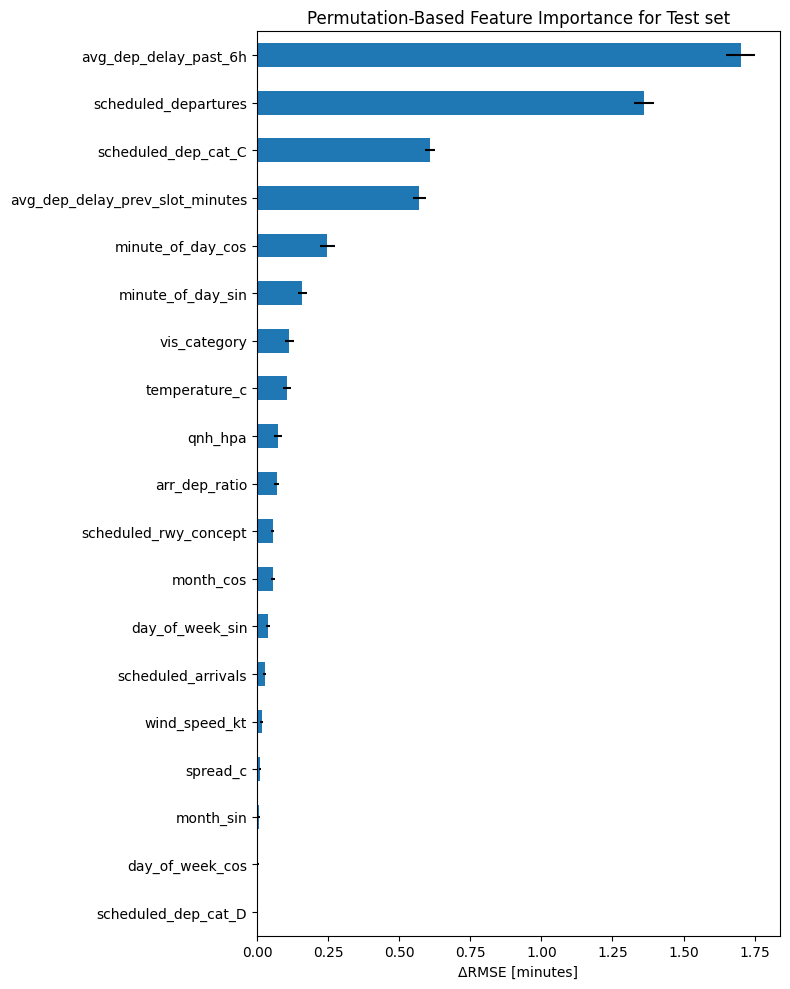

In [26]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
# Ensure y is 1-D
y_test_1d = y_test.values.ravel() # if y_val is a 1-col DataFrame

r = permutation_importance(
    model, X_test, y_test_1d,
    n_jobs=-1,
    n_repeats=100,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

# Build Series so indices align with feature names
imp_mean = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
imp_std  = pd.Series(r.importances_std,  index=X_test.columns).reindex(imp_mean.index)

plt.figure(figsize=(8,10))
imp_mean.head(20).plot(
    kind="barh",
    xerr=imp_std.head(20).values  # pass values to xerr
)
plt.gca().invert_yaxis()
plt.xlabel("ΔRMSE [minutes]")
plt.title("Permutation-Based Feature Importance for Test set")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go
import kaleido
kaleido.get_chrome_sync()

# Ensure y is 1-D
y_test_1d = y_test.values.ravel() # If y_test is a 1-column DataFrame

# Compute permutation importance
r = permutation_importance(
    model,
    X_test,
    y_test_1d,
    n_jobs=-1, # Use all available cores
    n_repeats=100, # Number of permutation rounds
    random_state=42, # For reproducibility. 42 means nothing special.
    scoring="neg_root_mean_squared_error" # Metric to evaluate
)

# Build Series so indices align with feature names
imp_mean = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
imp_std  = pd.Series(r.importances_std,  index=X_test.columns).reindex(imp_mean.index)

# Select top N features
top_n = 20 # Number of top features to display
imp_mean_top = imp_mean.head(top_n)[::-1] # Reverse for top-down display
imp_std_top  = imp_std.head(top_n)[::-1]

# -------------------------------------------------------------------
# 1) Mapping for feature labels on the y-axis (custom names)
# -------------------------------------------------------------------
feature_rename_map = {
    "avg_dep_delay_past_6h": "Avg. Departure Delay (Past 6h) [minutes]",
    "scheduled_departures": "Scheduled Departures",
    "scheduled_dep_cat_C": "Scheduled Departures (Cat. C)",
    "avg_dep_delay_prev_slot_minutes": "Avg. Departure Delay (Prev. Slot) [minutes]",
    "minute_of_day_cos": "Minute of Day (Cosine)",
    "minute_of_day_sin": "Minute of Day (Sine)",
    "vis_category": "Visibility Category",
    "temperature_c": "Temperature [°C]",
    "qnh_hpa": "QNH [hPa]",
    "arr_dep_ratio": "Arrival-Departure Ratio",
    "scheduled_rwy_concept": "Scheduled Runway Concept",
    "month_cos": "Month (Cosine)",
    "day_of_week_sin": "Day of Week (Sine)",
    "scheduled_arrivals": "Scheduled Arrivals",
    "wind_speed_kt": "Wind Speed [kt]",
    "spread_c": "Spread T-Td [°C]",
    "month_sin": "Month (Sine)",
    "day_of_week_cos": "Day of Week (Cosine)",
    "scheduled_dep_cat_D": "Scheduled Departures (Cat. D)",
}

# -------------------------------------------------------------------
# 2) Mapping for feature groups (to control bar colours and legend)
# -------------------------------------------------------------------
feature_group_map = {
    "avg_dep_delay_past_6h": "Operational Feature",
    "scheduled_departures": "Operational Feature",
    "scheduled_dep_cat_C": "Operational Feature",
    "avg_dep_delay_prev_slot_minutes": "Operational Feature",
    "minute_of_day_cos": "Temporal Feature",
    "minute_of_day_sin": "Temporal Feature",
    "vis_category": "Meteorological Feature",
    "temperature_c": "Meteorological Feature",
    "qnh_hpa": "Meteorological Feature",
    "arr_dep_ratio": "Operational Feature",
    "scheduled_rwy_concept": "Operational Feature",
    "month_cos": "Temporal Feature",
    "day_of_week_sin": "Temporal Feature",
    "scheduled_arrivals": "Operational Feature",
    "wind_speed_kt": "Meteorological Feature",
    "spread_c": "Meteorological Feature",
    "month_sin": "Temporal Feature",
    "day_of_week_cos": "Temporal Feature",
    "scheduled_dep_cat_D": "Operational Feature",
}

# Define colours for each group
group_colour_map = {
    "Operational Feature": "darkblue",
    "Temporal Feature": "darkorange",
    "Meteorological Feature": "darkgreen",
}

# -------------------------------------------------------------------
# Build a DataFrame for easier handling (labels + groups)
# -------------------------------------------------------------------
feat_df = pd.DataFrame({
    "feature": imp_mean_top.index,
    "mean": imp_mean_top.values,
    "std": imp_std_top.values
})

# Apply label mapping (for y-axis)
feat_df["label"] = feat_df["feature"].map(feature_rename_map).fillna(feat_df["feature"])

# Apply group mapping (for colours / legend); default group "Other"
feat_df["group"] = feat_df["feature"].map(feature_group_map).fillna("Other")

# Ensure every group has a colour (fallback to red)
default_colour = "red"
for g in feat_df["group"].unique():
    if g not in group_colour_map:
        group_colour_map[g] = default_colour

# -------------------------------------------------------------------
# Create Plotly figure (horizontal bar chart with error bars)
# Each group becomes its own trace, so the legend can explain colours.
# -------------------------------------------------------------------
fig = go.Figure()

# We keep the order of labels as in feat_df (already reversed top-down)
category_order = feat_df["label"].tolist()

for group_name, sub in feat_df.groupby("group"):
    fig.add_trace(
        go.Bar(
            x=sub["mean"],
            y=sub["label"],
            orientation="h",
            error_x=dict(
                type="data",
                array=sub["std"],
                visible=True,
                thickness=1, # Line thickness of the error bars
                width=4 # Width of the error bar caps
            ),
            marker=dict(color=group_colour_map[group_name]),
            name=group_name, # This shows up in the legend
            showlegend=True
        )
    )

# --- Adjust the layout to match the style of the histogram plot ---
fig.update_layout(
    height=800,
    width=1100,
    margin=dict(t=80, b=70),
    title=dict(
        text="Permutation-Based Feature Importance for Test Set (RMSE)",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    title_font=dict(size=20, family="Arial", color="black"),
    xaxis=dict(
        title="ΔRMSE [minutes]"
    ),
    yaxis=dict(
        title="Features",
        categoryorder="array",
        categoryarray=category_order # Preserve the desired top-down order
    ),
    legend=dict(
        title="Feature Groups",
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom"
    ),
    uniformtext_minsize=10,
    uniformtext_mode='show'
)

fig.show()
#fig.write_image("/Users/nathanaelrohr/Downloads/Permutation_Feature_Importance_RMSE.pdf")

In [ ]:
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go
import kaleido
kaleido.get_chrome_sync()

# Ensure y is 1-D
y_test_1d = y_test.values.ravel() # If y_test is a 1-column DataFrame

# Compute permutation importance using Mean Absolute Error
r = permutation_importance(
    model,
    X_test,
    y_test_1d,
    n_jobs=-1, # Use all available cores
    n_repeats=100, # Number of permutation rounds
    random_state=42, # For reproducibility
    scoring="neg_mean_absolute_error" # Use MAE instead of RMSE
)

# Build Series so indices align with feature names
imp_mean = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
imp_std  = pd.Series(r.importances_std,  index=X_test.columns).reindex(imp_mean.index)

# Select top N features
top_n = 20 # Number of top features to display
imp_mean_top = imp_mean.head(top_n)[::-1] # Reverse for top-down display
imp_std_top  = imp_std.head(top_n)[::-1]

# -------------------------------------------------------------------
# 1) Mapping for feature labels on the y-axis (custom names)
# -------------------------------------------------------------------
feature_rename_map = {
    "avg_dep_delay_past_6h": "Avg. Departure Delay (Past 6h) [minutes]",
    "scheduled_departures": "Scheduled Departures",
    "scheduled_dep_cat_C": "Scheduled Departures (Cat. C)",
    "avg_dep_delay_prev_slot_minutes": "Avg. Departure Delay (Prev. Slot) [minutes]",
    "minute_of_day_cos": "Minute of Day (Cosine)",
    "minute_of_day_sin": "Minute of Day (Sine)",
    "vis_category": "Visibility Category",
    "temperature_c": "Temperature [°C]",
    "qnh_hpa": "QNH [hPa]",
    "arr_dep_ratio": "Arrival-Departure Ratio",
    "scheduled_rwy_concept": "Scheduled Runway Concept",
    "month_cos": "Month (Cosine)",
    "day_of_week_sin": "Day of Week (Sine)",
    "scheduled_arrivals": "Scheduled Arrivals",
    "wind_speed_kt": "Wind Speed [kt]",
    "spread_c": "Spread T-Td [°C]",
    "month_sin": "Month (Sine)",
    "day_of_week_cos": "Day of Week (Cosine)",
    "scheduled_dep_cat_D": "Scheduled Departures (Cat. D)",
}

# -------------------------------------------------------------------
# 2) Mapping for feature groups (to control bar colours and legend)
# -------------------------------------------------------------------
feature_group_map = {
    "avg_dep_delay_past_6h": "Operational Feature",
    "scheduled_departures": "Operational Feature",
    "scheduled_dep_cat_C": "Operational Feature",
    "avg_dep_delay_prev_slot_minutes": "Operational Feature",
    "minute_of_day_cos": "Temporal Feature",
    "minute_of_day_sin": "Temporal Feature",
    "vis_category": "Meteorological Feature",
    "temperature_c": "Meteorological Feature",
    "qnh_hpa": "Meteorological Feature",
    "arr_dep_ratio": "Operational Feature",
    "scheduled_rwy_concept": "Operational Feature",
    "month_cos": "Temporal Feature",
    "day_of_week_sin": "Temporal Feature",
    "scheduled_arrivals": "Operational Feature",
    "wind_speed_kt": "Meteorological Feature",
    "spread_c": "Meteorological Feature",
    "month_sin": "Temporal Feature",
    "day_of_week_cos": "Temporal Feature",
    "scheduled_dep_cat_D": "Operational Feature",
}

# Define colours for each group
group_colour_map = {
    "Operational Feature": "darkblue",
    "Temporal Feature": "darkorange",
    "Meteorological Feature": "darkgreen",
}

# -------------------------------------------------------------------
# Build a DataFrame for easier handling (labels + groups)
# -------------------------------------------------------------------
feat_df = pd.DataFrame({
    "feature": imp_mean_top.index,
    "mean": imp_mean_top.values,
    "std": imp_std_top.values
})

# Apply label mapping (for y-axis)
feat_df["label"] = feat_df["feature"].map(feature_rename_map).fillna(feat_df["feature"])

# Apply group mapping (for colours / legend); default group "Other"
feat_df["group"] = feat_df["feature"].map(feature_group_map).fillna("Other")

# Ensure every group has a colour (fallback to red)
default_colour = "red"
for g in feat_df["group"].unique():
    if g not in group_colour_map:
        group_colour_map[g] = default_colour

# -------------------------------------------------------------------
# Create Plotly figure (horizontal bar chart with error bars)
# Each group becomes its own trace, so the legend can explain colours.
# -------------------------------------------------------------------
fig = go.Figure()

# We keep the order of labels as in feat_df (already reversed top-down)
category_order = feat_df["label"].tolist()

for group_name, sub in feat_df.groupby("group"):
    fig.add_trace(
        go.Bar(
            x=sub["mean"],
            y=sub["label"],
            orientation="h",
            error_x=dict(
                type="data",
                array=sub["std"],
                visible=True,
                thickness=1, # Line thickness of the error bars
                width=4 # Width of the error bar caps
            ),
            marker=dict(color=group_colour_map[group_name]),
            name=group_name, # This shows up in the legend
            showlegend=True
        )
    )

# --- Adjust the layout to match the style of the histogram plot ---
fig.update_layout(
    height=800,
    width=1100,
    margin=dict(t=80, b=70),
    title=dict(
        text="Permutation-Based Feature Importance for Test Set (MAE)",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    title_font=dict(size=20, family="Arial", color="black"),
    xaxis=dict(
        title="ΔMAE [minutes]",
        range=[0, 2.5]
    ),
    yaxis=dict(
        title="Features",
        categoryorder="array",
        categoryarray=category_order # Preserve the desired top-down order
    ),
    legend=dict(
        title="Feature Groups",
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom"
    ),
    uniformtext_minsize=10,
    uniformtext_mode='show'
)

fig.show()
#fig.write_image("/Users/nathanaelrohr/Downloads/Permutation_Feature_Importance_MAE.pdf")

/Users/nathanaelrohr/Documents/VSCode/PA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



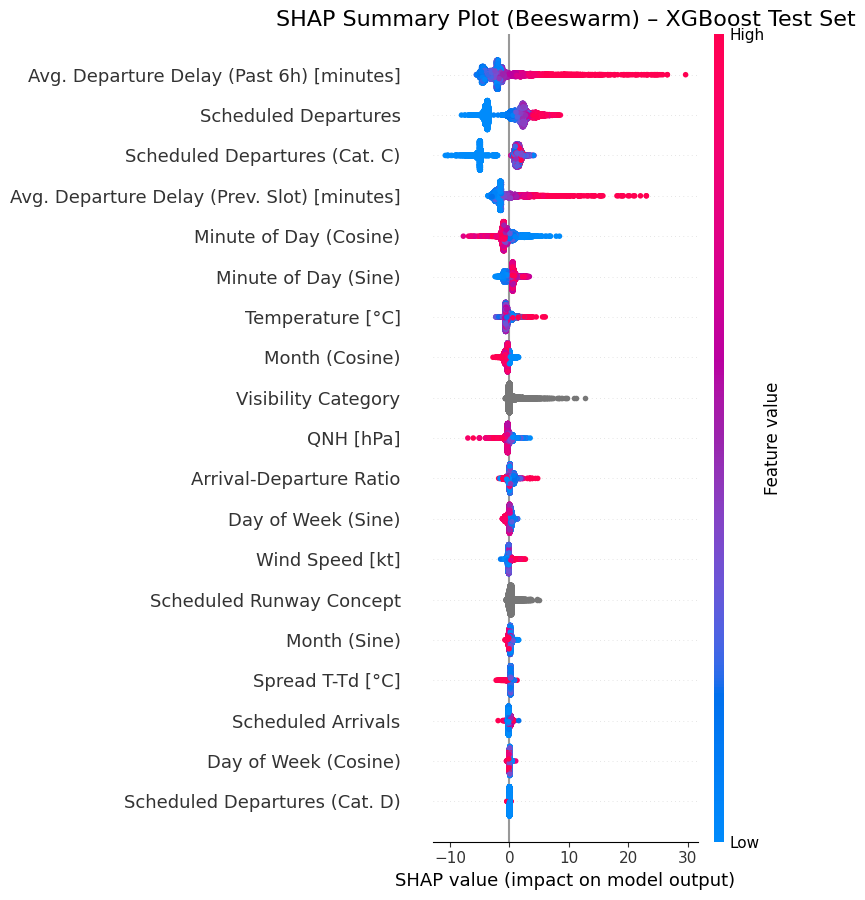

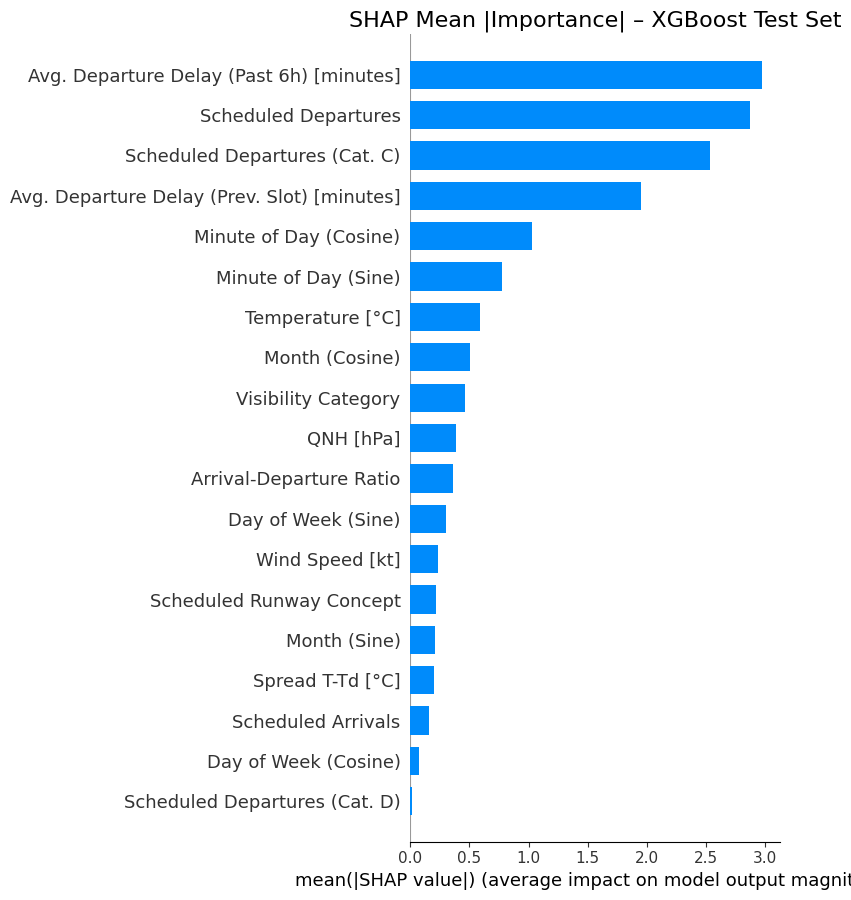

In [29]:
import shap
import matplotlib.pyplot as plt

# --- 1. SHAP initialisation (for Jupyter, optional but handy) ---
shap.initjs()

# --- 2. TreeExplainer für XGBoost-Modell ---
# model: dein trainiertes XGBoost-Regressionsmodell (z.B. xgboost.XGBRegressor)
explainer = shap.TreeExplainer(model)

# --- 3. SHAP-Werte für den Testdatensatz berechnen ---
X_shap = X_test # vollständiger Testdatensatz

shap_values = explainer(X_shap)

# --- 4. Feature-Namen hübsch machen (wie bei deinem PFI-Plot) ---
feature_rename_map = {
    "avg_dep_delay_past_6h": "Avg. Departure Delay (Past 6h) [minutes]",
    "scheduled_departures": "Scheduled Departures",
    "scheduled_dep_cat_C": "Scheduled Departures (Cat. C)",
    "avg_dep_delay_prev_slot_minutes": "Avg. Departure Delay (Prev. Slot) [minutes]",
    "minute_of_day_cos": "Minute of Day (Cosine)",
    "minute_of_day_sin": "Minute of Day (Sine)",
    "vis_category": "Visibility Category",
    "temperature_c": "Temperature [°C]",
    "qnh_hpa": "QNH [hPa]",
    "arr_dep_ratio": "Arrival-Departure Ratio",
    "scheduled_rwy_concept": "Scheduled Runway Concept",
    "month_cos": "Month (Cosine)",
    "day_of_week_sin": "Day of Week (Sine)",
    "scheduled_arrivals": "Scheduled Arrivals",
    "wind_speed_kt": "Wind Speed [kt]",
    "spread_c": "Spread T-Td [°C]",
    "month_sin": "Month (Sine)",
    "day_of_week_cos": "Day of Week (Cosine)",
    "scheduled_dep_cat_D": "Scheduled Departures (Cat. D)",
}

pretty_feature_names = [
    feature_rename_map.get(col, col) for col in X_shap.columns
]

# --- 5. SHAP Summary / Beeswarm Plot ---
plt.figure(figsize=(10, 8))

shap.summary_plot(
    shap_values.values, # SHAP-Werte (Samples × Features)
    X_shap, # Originale Feature-Werte
    feature_names=pretty_feature_names,
    show=False # Erst zeichnen, dann Layout anpassen
)

plt.title("SHAP Summary Plot (Beeswarm) – XGBoost Test Set", fontsize=16)
plt.tight_layout()
plt.show()
#plt.savefig("/Users/nathanaelrohr/Downloads/SHAP_Summary_Beeswarm_XGB.pdf", dpi=300, bbox_inches="tight")

# --- 6. SHAP Bar-Plot (globale Wichtigkeiten nach |SHAP|) ---
plt.figure(figsize=(8, 6))

shap.summary_plot(
    shap_values.values,
    X_shap,
    feature_names=pretty_feature_names,
    plot_type="bar",
    show=False
)

plt.title("SHAP Mean |Importance| – XGBoost Test Set", fontsize=16)
plt.tight_layout()
plt.show()
#plt.savefig("/Users/nathanaelrohr/Downloads/SHAP_Summary_Bar_XGB.pdf", dpi=300, bbox_inches="tight")

Predicted vs. Actual Delays Test-Set

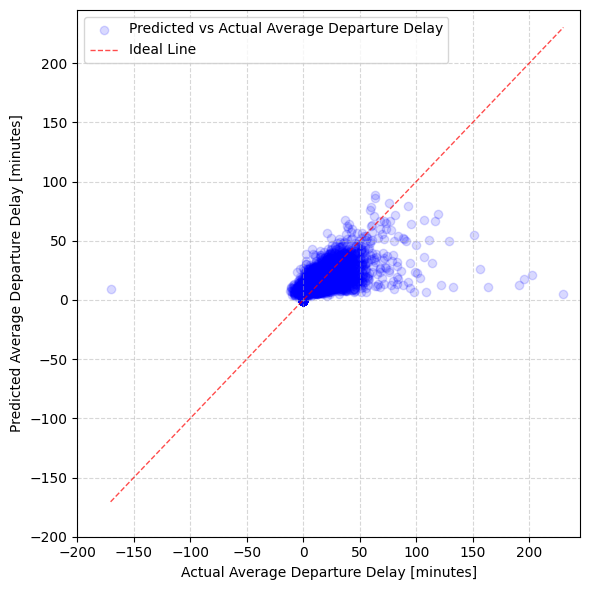

In [33]:
# y_test and y_test_pred already exist
 
y_true = y_test.squeeze()
y_pred = y_pred_test.squeeze()
 
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.15, color='blue',label="Predicted vs Actual Average Departure Delay")
 
# Perfect prediction line
lims = [min(y_true.min(), y_pred.min()),
        max(y_true.max(), y_pred.max())]
 
plt.plot(lims, lims, linestyle="--", color="red", linewidth=1,label='Ideal Line',alpha=0.7)
plt.xlim(-200, 245)
plt.ylim(-200, 245)
 
plt.xlabel("Actual Average Departure Delay [minutes]")
plt.ylabel("Predicted Average Departure Delay [minutes]")
#plt.title("Predicted vs Actual Departure Delays")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.xlim(-200, 245)
plt.ylim(-200, 245)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Ensure y_true and y_pred are 1-D sequences
y_true = y_test.squeeze()
y_pred = y_pred_test.squeeze()

# Define axis limits (same as in the Matplotlib version)
x_min, x_max = -200, 245
y_min, y_max = -200, 245

# Create the ideal prediction line (y = x)
ideal_x = [x_min, x_max]
ideal_y = [x_min, x_max]

# Create Plotly figure
fig = go.Figure()

# Scatter of predicted vs actual
fig.add_trace(
    go.Scatter(
        x=y_true,
        y=y_pred,
        mode="markers",
        name="Predicted vs Actual",
        marker=dict(
            color="navy",
            size=7,
            opacity=0.35
        )
    )
)

# Ideal line (perfect predictions)
fig.add_trace(
    go.Scatter(
        x=ideal_x,
        y=ideal_y,
        mode="lines",
        name="Ideal Line",
        line=dict(
            color="red",
            width=1,
            dash="dash"
        )
    )
)

# Update layout to match the style of your other Plotly plots
fig.update_layout(
    height=800,
    width=800,
    margin=dict(t=80, b=70),
    title=dict(
        text="Predicted vs Actual Average Departure Delay",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    title_font=dict(size=20, family="Arial", color="black"),
    xaxis=dict(
        title="Actual Average Departure Delay [minutes]",
        range=[x_min, x_max]
    ),
    yaxis=dict(
        title="Predicted Average Departure Delay [minutes]",
        range=[y_min, y_max],
        scaleanchor="x", # Keep equal scaling on both axes
        scaleratio=1
    ),
    legend=dict(
        title="Legend",
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom"
    )
)

# Optional: light grid similar to your Matplotlib style
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")

fig.show()
#fig.write_image("/Users/nathanaelrohr/Downloads/Predicted_vs_Actual_Departure_Delay.pdf")

Residuals vs Predicted Delay

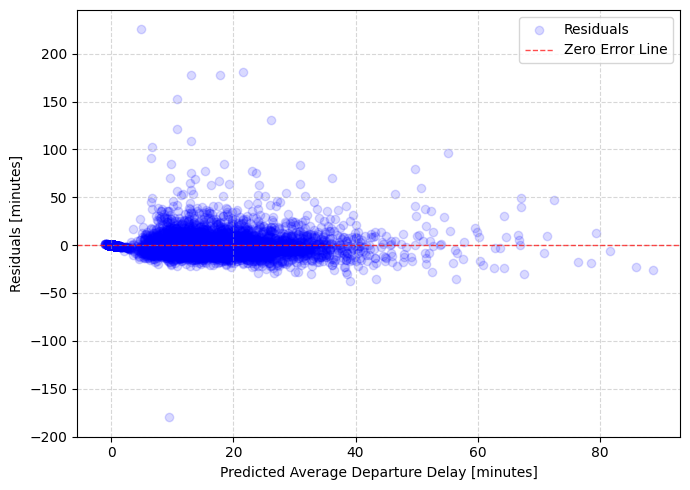

In [34]:
y_true = y_test.squeeze()          # Series or 1D array
y_pred = y_pred_test.squeeze()     # 1D array
 
residuals = y_true - y_pred
 
plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.15, color='blue',label="Residuals")
plt.axhline(0, color="red", alpha=0.7, linestyle="--", lw=1,label='Zero Error Line')
 
#plt.title("Residuals vs Predicted Average Departure Delay")
plt.xlabel("Predicted Average Departure Delay [minutes]")
plt.ylabel("Residuals [minutes]")
 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Ensure y_true and y_pred are 1-D
y_true = y_test.squeeze()
y_pred = y_pred_test.squeeze()

# Compute residuals
residuals = y_true - y_pred

ymin_res = -200
ymax_res = 245

# Create figure
fig = go.Figure()

# Scatter der Residuen
fig.add_trace(
    go.Scatter(
        x=y_pred,
        y=residuals,
        mode="markers",
        name="Residuals",
        marker=dict(
            color="navy",
            size=7,
            opacity=0.35
        )
    )
)

# Horizontale Linie bei 0 (Zero Error Line)
fig.add_trace(
    go.Scatter(
        x=[-10, 95],
        y=[0, 0],
        mode="lines",
        name="Zero Error Line",
        line=dict(
            color="red",
            width=1.5,
            dash="dash"
        )
    )
)

# Layout an Stil der anderen Plotly-Grafiken anpassen
fig.update_layout(
    height=600,
    width=1000,
    margin=dict(t=80, b=70),
    title=dict(
        text="Residuals vs Predicted Average Departure Delay",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    title_font=dict(size=20, family="Arial", color="black"),
    xaxis=dict(
        title="Predicted Average Departure Delay [minutes]"
    ),
    yaxis=dict(
        title="Residuals [minutes]",
        range=[ymin_res, ymax_res]
    ),
    legend=dict(
        title="Legend",
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom"
    )
)

# Dezentes Grid wie bei den anderen Plots
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")

fig.show()
#fig.write_image("/Users/nathanaelrohr/Downloads/Residuals_vs_Predicted_Departure_Delay.pdf")

Residuals vs Actual Delay

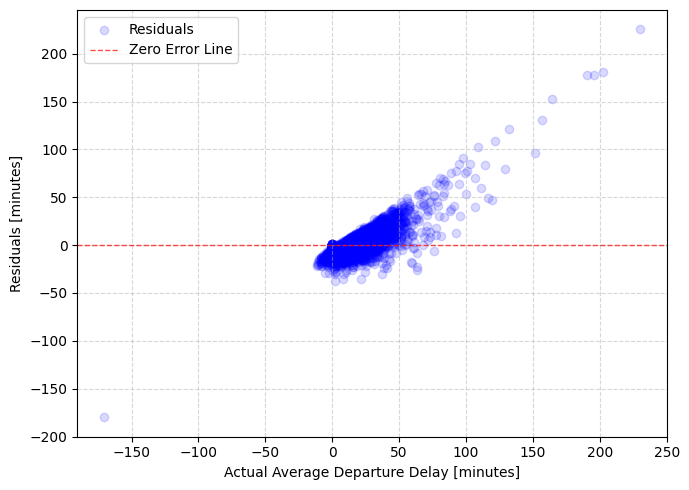

In [35]:
# 1) Make y_test a 1-D Series
y_true = y_test.squeeze()
 
# 2) Wrap predictions in a Series with the same index
y_pred = pd.Series(y_pred_test.squeeze(), index=y_true.index)
 
# 3) Residuals
residuals = y_true - y_pred
 
# 4) Residuals vs ACTUAL plot
plt.figure(figsize=(7,5))
plt.scatter(y_true, residuals, alpha=0.15, color='blue',label="Residuals")
 
plt.axhline(0, color="red", alpha=0.7, linestyle="--", lw=1,label='Zero Error Line')
 
#plt.title("Residuals vs Actual Average Departure Delay")
plt.xlabel("Actual Average Departure Delay [minutes]")
plt.ylabel("Residuals [minutes]")
 
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

# 1) Make y_test a 1-D Series
y_true = y_test.squeeze()

# 2) Wrap predictions in a Series with the same index
y_pred = pd.Series(y_pred_test.squeeze(), index=y_true.index)

# 3) Residuals
residuals = y_true - y_pred

# Optionale y-Achsen-Grenzen
ymin_res = -200
ymax_res = 245

# Create figure
fig = go.Figure()

# Scatter of residuals vs actual
fig.add_trace(
    go.Scatter(
        x=y_true,
        y=residuals,
        mode="markers",
        name="Residuals",
        marker=dict(
            color="navy",
            size=7,
            opacity=0.35
        )
    )
)

# Horizontal zero-error line
fig.add_trace(
    go.Scatter(
        x=[y_true.min(), y_true.max()],
        y=[0, 0],
        mode="lines",
        name="Zero Error Line",
        line=dict(
            color="red",
            width=1.5,
            dash="dash"
        )
    )
)

# Layout to match the style of your other Plotly figures
fig.update_layout(
    height=800,
    width=900,
    margin=dict(t=80, b=70),
    title=dict(
        text="Residuals vs Actual Average Departure Delay",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    title_font=dict(size=20, family="Arial", color="black"),
    xaxis=dict(
        title="Actual Average Departure Delay [minutes]"
    ),
    yaxis=dict(
        title="Residuals [minutes]",
        range=[ymin_res, ymax_res]
    ),
    legend=dict(
        title="Legend",
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom"
    )
)

# Subtle grid, matching your other plots
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")

fig.show()
#fig.write_image("/Users/nathanaelrohr/Downloads/Residuals_vs_Actual_Departure_Delay.pdf")

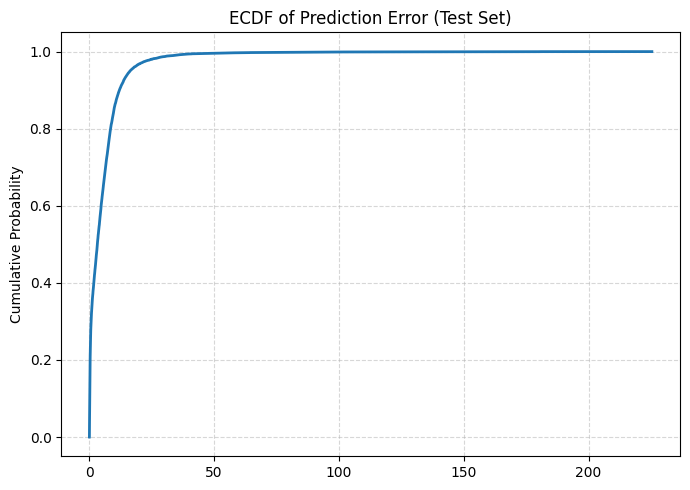

In [39]:
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
 
# Assuming you already have y_true and y_pred
errors = np.absolute(y_pred - y_true)
 
# Create ECDF object
ecdf = ECDF(errors)
 
# Plot
plt.figure(figsize=(7,5))
plt.plot(ecdf.x, ecdf.y, linewidth=2)
 
# Zero-error reference
#plt.axvline(0, color="red", linestyle="--", alpha=0.7)
#plt.xlabel("Absolute Error [minutes]")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Prediction Error (Test Set)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [78]:
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import plotly.graph_objects as go

# Assuming you already have y_true and y_pred defined
errors = np.absolute(y_pred - y_true)

# Create ECDF object
ecdf = ECDF(errors)

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ecdf.x,
        y=ecdf.y,
        mode="lines",
        name="ECDF",
        line=dict(
            width=3,
            color="navy"
        )
    )
)

# Layout in the same style as your other Plotly plots
fig.update_layout(
    height=800,
    width=900,
    margin=dict(t=80, b=70),
    title=dict(
        text="ECDF of Prediction Error (Test Set)",
        x=0.5,
        xanchor="center",
        yanchor="top"
    ),
    title_font=dict(size=20, family="Arial", color="black"),
    xaxis=dict(
        title="Absolute Error [minutes]",
        range=[-5, 230]
    ),
    yaxis=dict(
        title="Cumulative Probability",
        range=[-0.05, 1.05]
    ),
    legend=dict(
        title="Legend",
        x=0.99,
        y=0.01,
        xanchor="right",
        yanchor="bottom"
    )
)

# Dezentes Grid, wie gewohnt
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")

fig.show()
#fig.write_image("/Users/nathanaelrohr/Downloads/ECDF_Prediction_Error_TestSet.pdf")